In [1]:
%%capture
# Install the vncorenlp python wrapper
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [2]:
!pip install openpyxl  --quiet

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
ENCODER_LEN = 300
DECODER_LEN = 60
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8

In [5]:
filename = r"../input/summary-vietnamese/data_summary.csv"
df = pd.read_csv(filename).drop('Unnamed: 0',1)
print(f'Dataset size: {len(df)}')
df.head(5)

Dataset size: 102681


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,Summary,Text
0,Ngay khi bắt tay ai đó có thể chúng ta đã cảm ...,Tổng thống Mỹ Donald Trump và Tổng thống Pháp ...
1,"Rời khỏi Việt Nam vào 10/2016, ông Vũ Đình Duy...",Vũ Đình Duy hồi tháng 5 xuất hiện trước tòa tạ...
2,Thủ tướng Iraq xác nhận với BBC rằng Syria khô...,Ông Maliki xác nhận các vụ không kích của Syri...
3,Người Việt Nam biết rất ít về ông Trump nhưng ...,Tiến sỹ Vũ Cao Phan tin rằng nếu được tiến hàn...
4,Bốn khoa học gia người Mỹ từng đoạt giải Nobel...,GS Jack Steinberger trao đổi với GS Lê Kim Ngọ...


In [6]:
'''Loại bỏ các giá trị trùng lặp và giá trị rỗng'''

df.drop_duplicates(subset=['Text'],inplace=True) #dropping duplicates
df.dropna(axis=0,inplace=True) #dropping na
df = df.reset_index().drop('index', axis = 1)
print(f'Dataset size: {len(df)}')
df.head(5)

Dataset size: 96284


,Summary,Text
0,Ngay khi bắt tay ai đó có thể chúng ta đã cảm ...,Tổng thống Mỹ Donald Trump và Tổng thống Pháp ...
1,"Rời khỏi Việt Nam vào 10/2016, ông Vũ Đình Duy...",Vũ Đình Duy hồi tháng 5 xuất hiện trước tòa tạ...
2,Thủ tướng Iraq xác nhận với BBC rằng Syria khô...,Ông Maliki xác nhận các vụ không kích của Syri...
3,Người Việt Nam biết rất ít về ông Trump nhưng ...,Tiến sỹ Vũ Cao Phan tin rằng nếu được tiến hàn...
4,Bốn khoa học gia người Mỹ từng đoạt giải Nobel...,GS Jack Steinberger trao đổi với GS Lê Kim Ngọ...


# Data preparation

In [7]:
def cleanWord(s):
    miss = ['!','@','#','$','%','^','&','*','(',')','-','–','_','+','=','{','[','}',']','|',':',';','?','/','<','>','~','`','‘','’',',','()','“','"', '...','”', '“”','\\', '>>', '>>>']
    for i in miss:
        s = s.replace(i,'')
    return re.sub(r'\'', '', s)

def remove_link(string):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', string)

def remove_extra_whitespace(string):
    text = re.sub(r'\s+', ' ', string).strip()
    return text

def lower_word(data):
    return data.lower()

# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [alphabet for alphabet in word if alphabet not in string.punctuation]
    return ''.join(clean_alphabet_list)

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)


# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_number_from_text(text)
    text = rm_punc_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

def solve(string):
    func = [lower_word, remove_link, remove_extra_whitespace, cleanWord, clean_text]
    for i in func:
        string = i(string)
    return string

In [8]:
df.Text = df.Text.apply(lambda x: solve(str(x)))
df.Summary = df.Summary.apply(lambda x: solve(str(x)))
df.head(5)

,Summary,Text
0,ngay khi bắt tay ai đó có thể chúng ta đã cảm ...,tổng thống mỹ donald trump và tổng thống pháp ...
1,rời khỏi việt nam vào ông vũ đình duy tới sống...,vũ đình duy hồi tháng xuất hiện trước tòa tại ...
2,thủ tướng iraq xác nhận với bbc rằng syria khô...,ông maliki xác nhận các vụ không kích của syri...
3,người việt nam biết rất ít về ông trump nhưng ...,tiến sỹ vũ cao phan tin rằng nếu được tiến hàn...
4,bốn khoa học gia người mỹ từng đoạt giải nobel...,gs jack steinberger trao đổi với gs lê kim ngọ...


Finding what should be the **maximum length** of **Text** and **Summary** that will be feed or accepted by the learning algorithm

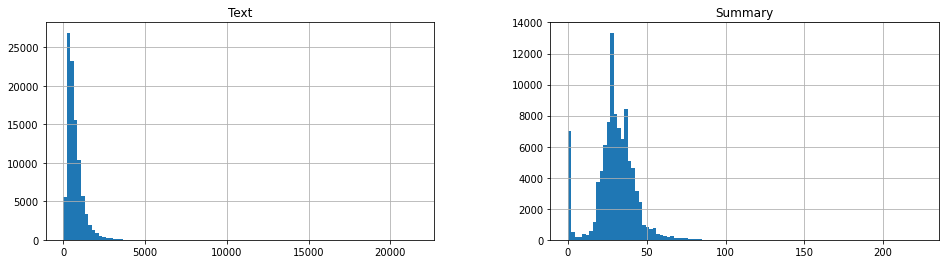

In [9]:
text_count = [len(sentence.split()) for sentence in df.Text]
summary_count = [len(sentence.split()) for sentence in df.Summary]

pd.DataFrame({'Text': text_count, 'Summary': summary_count}).hist(bins=100, figsize=(16, 4))
plt.show()

In [10]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of summary have 0-60 words
print(get_word_percent(df.Summary, 60))

# Check how many % of text have 0-300 words
print(get_word_percent(df.Text, 300))

0.99
0.15


In [11]:
max_text_len = 300
max_summary_len = 60

In [12]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['Text'])
    cleaned_summary = np.array(df['Summary'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'Text': short_text, 'Summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.head(5)

Dataset size: 14664


,Text,Summary
0,ông maliki xác nhận các vụ không kích của syri...,thủ tướng iraq xác nhận với bbc rằng syria khô...
1,lý quang diệu được cho là người đứng đằng sau...,chính phủ singapore cho hay cựu thủ tướng ngườ...
2,ông hà kim ngọc thứ trưởng bộ ngoại giao phát ...,kết thúc phiên kiểm định định kỳ phổ quát về t...
3,hai bàn thắng của luis suarez hiệp một tạo lợi...,hlv manchester city manuel pellegrini tin rằng...
4,thủ hiến tiểu bang nam úc ông jay weatherill l...,một chính khách gốc việt từng là dân tỵ nạn ...


In [13]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g') 

In [14]:
def read_content(string):
    original = rdrsegmenter.tokenize(string)
    original = ' '.join([' '.join(x) for x in original])

    return original

In [15]:
df.Text = df.Text.apply(lambda x: read_content(str(x)))
df.Summary = df.Summary.apply(lambda x: read_content(str(x)))
df.head(5)

,Text,Summary
0,ông maliki xác_nhận các vụ không_kích của syri...,thủ_tướng iraq xác_nhận với bbc rằng syria khô...
1,lý quang diệu được cho là người đứng đằng sau...,chính_phủ singapore cho_hay cựu thủ_tướng ngườ...
2,ông hà kim ngọc thứ_trưởng bộ ngoại_giao phát_...,kết_thúc phiên kiểm_định định_kỳ phổ_quát về t...
3,hai bàn thắng của luis suarez hiệp một tạo lợi...,hlv manchester city manuel pellegrini tin rằng...
4,thủ_hiến tiểu_bang nam úc ông jay weatherill l...,một chính_khách gốc việt từng là dân tỵ nạn ...


In [16]:
article = df['Text']
summary = df['Summary']
article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [17]:
filters = '!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [18]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

32935 17737


In [19]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

2022-05-14 17:06:53.105891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 17:06:53.232632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 17:06:53.233531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 17:06:53.237324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [24]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [25]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [27]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 30

# Custom Learning Rate

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [29]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

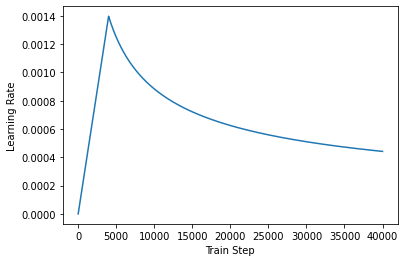

In [30]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Custom Loss and Accuracy

In [31]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [32]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [33]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [34]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [35]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [36]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

# Training the Model

In [37]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

2022-05-14 17:07:04.411996: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1 Batch 0 Loss 9.7937 Accuracy 0.0000
Epoch 1 Batch 100 Loss 9.7037 Accuracy 0.0328
Epoch 1 Batch 200 Loss 9.5180 Accuracy 0.0380
Epoch 1 Loss 9.4386 Accuracy 0.0386
Time taken for 1 epoch: 41.53263783454895 secs

Epoch 2 Batch 0 Loss 8.8213 Accuracy 0.0386
Epoch 2 Batch 100 Loss 8.4018 Accuracy 0.0465
Epoch 2 Batch 200 Loss 8.1119 Accuracy 0.0457
Epoch 2 Loss 8.0341 Accuracy 0.0455
Time taken for 1 epoch: 31.448057651519775 secs

Epoch 3 Batch 0 Loss 7.5781 Accuracy 0.0455
Epoch 3 Batch 100 Loss 7.4654 Accuracy 0.0489
Epoch 3 Batch 200 Loss 7.4929 Accuracy 0.0482
Epoch 3 Loss 7.4713 Accuracy 0.0483
Time taken for 1 epoch: 31.416637182235718 secs

Epoch 4 Batch 0 Loss 7.5099 Accuracy 0.0482
Epoch 4 Batch 100 Loss 7.2872 Accuracy 0.0510
Epoch 4 Batch 200 Loss 7.3044 Accuracy 0.0511
Epoch 4 Loss 7.2742 Accuracy 0.0513
Time taken for 1 epoch: 31.419694423675537 secs

Epoch 5 Batch 0 Loss 7.3028 Accuracy 0.0513
Epoch 5 Batch 100 Loss 6.9309 Accuracy 0.0541
Epoch 5 Batch 200 Loss 6.94

# Evaluation

In [38]:
def evaluate(input_article):
    input_article = article_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [39]:
def summarize(input_article):
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  
    return summary_tokenizer.sequences_to_texts(summarized)[0]

# Predictions

In [40]:
article[16]

'<SOS> trong dịp này ông cũng bày_tỏ cam_kết mạnh_mẽ của chính_phủ anh trong việc phòng_chống nạn mua_bán người và ngăn_chặn những thảm_kịch tương_tự tái_diễn đợt đầu_tiên vận_chuyển thi_hài nạn_nhân trong vụ xe_tải anh về tới việt_nam thi_hài được chuyển từ sân_bay london heathrow hôm và về tới sân_bay nội bài hà_nội vào sáng hôm thứ tư bản tin bảo_hộ công_dân của bộ ngoại_giao việt_nam xác_nhận việc tiếp_nhận thi_hài này sáng ngày thực_hiện chỉ_đạo của thủ_tướng chính_phủ bộ ngoại_giao đã phối_hợp với các cơ_quan_chức_năng và địa_phương trong nước đưa trong tổng_số thi hàidi hài của các nạn_nhân thiệt_mạng tại hạt essex đông bắc london anh về tới sân_bay nội bài ngay sau khi hạ_cánh đại_diện các địa_phương có người bị nạn là nghệ_an hà_tĩnh và quảng_bình đã tiếp_nhận và đưa nạn_nhân về địa_phương để bàn_giao cho gia_đình bản tin này mô_tả hiện các cơ_quan_chức_năng của việt_nam và anh đang tiếp_tục phối_hợp chặt_chẽ để sớm đưa các nạn_nhân còn lại về nước truyền_thông trong nước đưa 

In [41]:
print("Original summary : ", summary[16][5:-5],"\nPredicted Summary : ", summarize(article[16]))

Original summary :   đại_sứ anh tại việt_nam ngài gareth ward chia buồn cùng nạn_nhân thảm_kịch người trên xe thùng  
Predicted Summary :  một cặp vợ_chồng trẻ tuổi đã bị cục đăng_kiểm đức_thọ hà_tĩnh phát_hiện và một trong một cụ_già trên đường đi qua


In [42]:
print("Original summary : ", summary[15][5:-5],"\nPredicted Summary : ", summarize(article[15]))

Original summary :   uỷ_ban châu_âu công_bố kế_hoạch cho_phép người tị_nạn vào châu_âu trong hai năm tới để đối_phó khủng_hoảng di_dân  
Predicted Summary :  một chuyên_gia về trụ_sở của tờ china daily của nga đã có thêm nhiều loại xe khác nhau thông_qua nền_tảng game tại khu_vực


# Calculating Rouge Scores

In [43]:
reference = []
hypothesis = []


for i in range(0, 100):
    reference.append(summary[i][5:-5])
    hypothesis.append(summarize(article[i]))

In [44]:
! pip install rouge

In [45]:
from rouge import Rouge

In [46]:
score = Rouge()
score.get_scores(hypothesis, reference, avg = True)

{'rouge-1': {'r': 0.0948441733622093,
  'p': 0.09105246388697155,
  'f': 0.08983147148830435},
 'rouge-2': {'r': 0.006848283960048666,
  'p': 0.006755654472262615,
  'f': 0.006644484537027826},
 'rouge-l': {'r': 0.07519482602442515,
  'p': 0.07293393369559728,
  'f': 0.07162781743731786}}